## Import Libraries

#### pandas, matplotlib, seaborn

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MaxNLocator
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

import seaborn as sns
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

from pylab import rcParams
rcParams['figure.figsize'] = 16, 10

from multiprocessing import cpu_count

#### pytorch, pytorch_lightning

In [2]:
from tqdm.auto import tqdm

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from torchmetrics.functional import accuracy

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

/home/dema/anaconda3/envs/secml_venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### sklearn

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

#### Seed everything to make results reproducible

In [4]:
pl.seed_everything(42)

Seed set to 42


42

## Preprocessing

#### Load and examine datasets

In [5]:
X_train = pd.read_csv("./data_HelpNavigateRobot/X_train.csv")
y_train = pd.read_csv("./data_HelpNavigateRobot/y_train.csv")

In [6]:
X_train.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003386,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410


In [7]:
y_train.head()

,series_id,group_id,surface
0,0,13,fine_concrete
1,1,31,concrete
2,2,20,concrete
3,3,31,concrete
4,4,22,soft_tiles


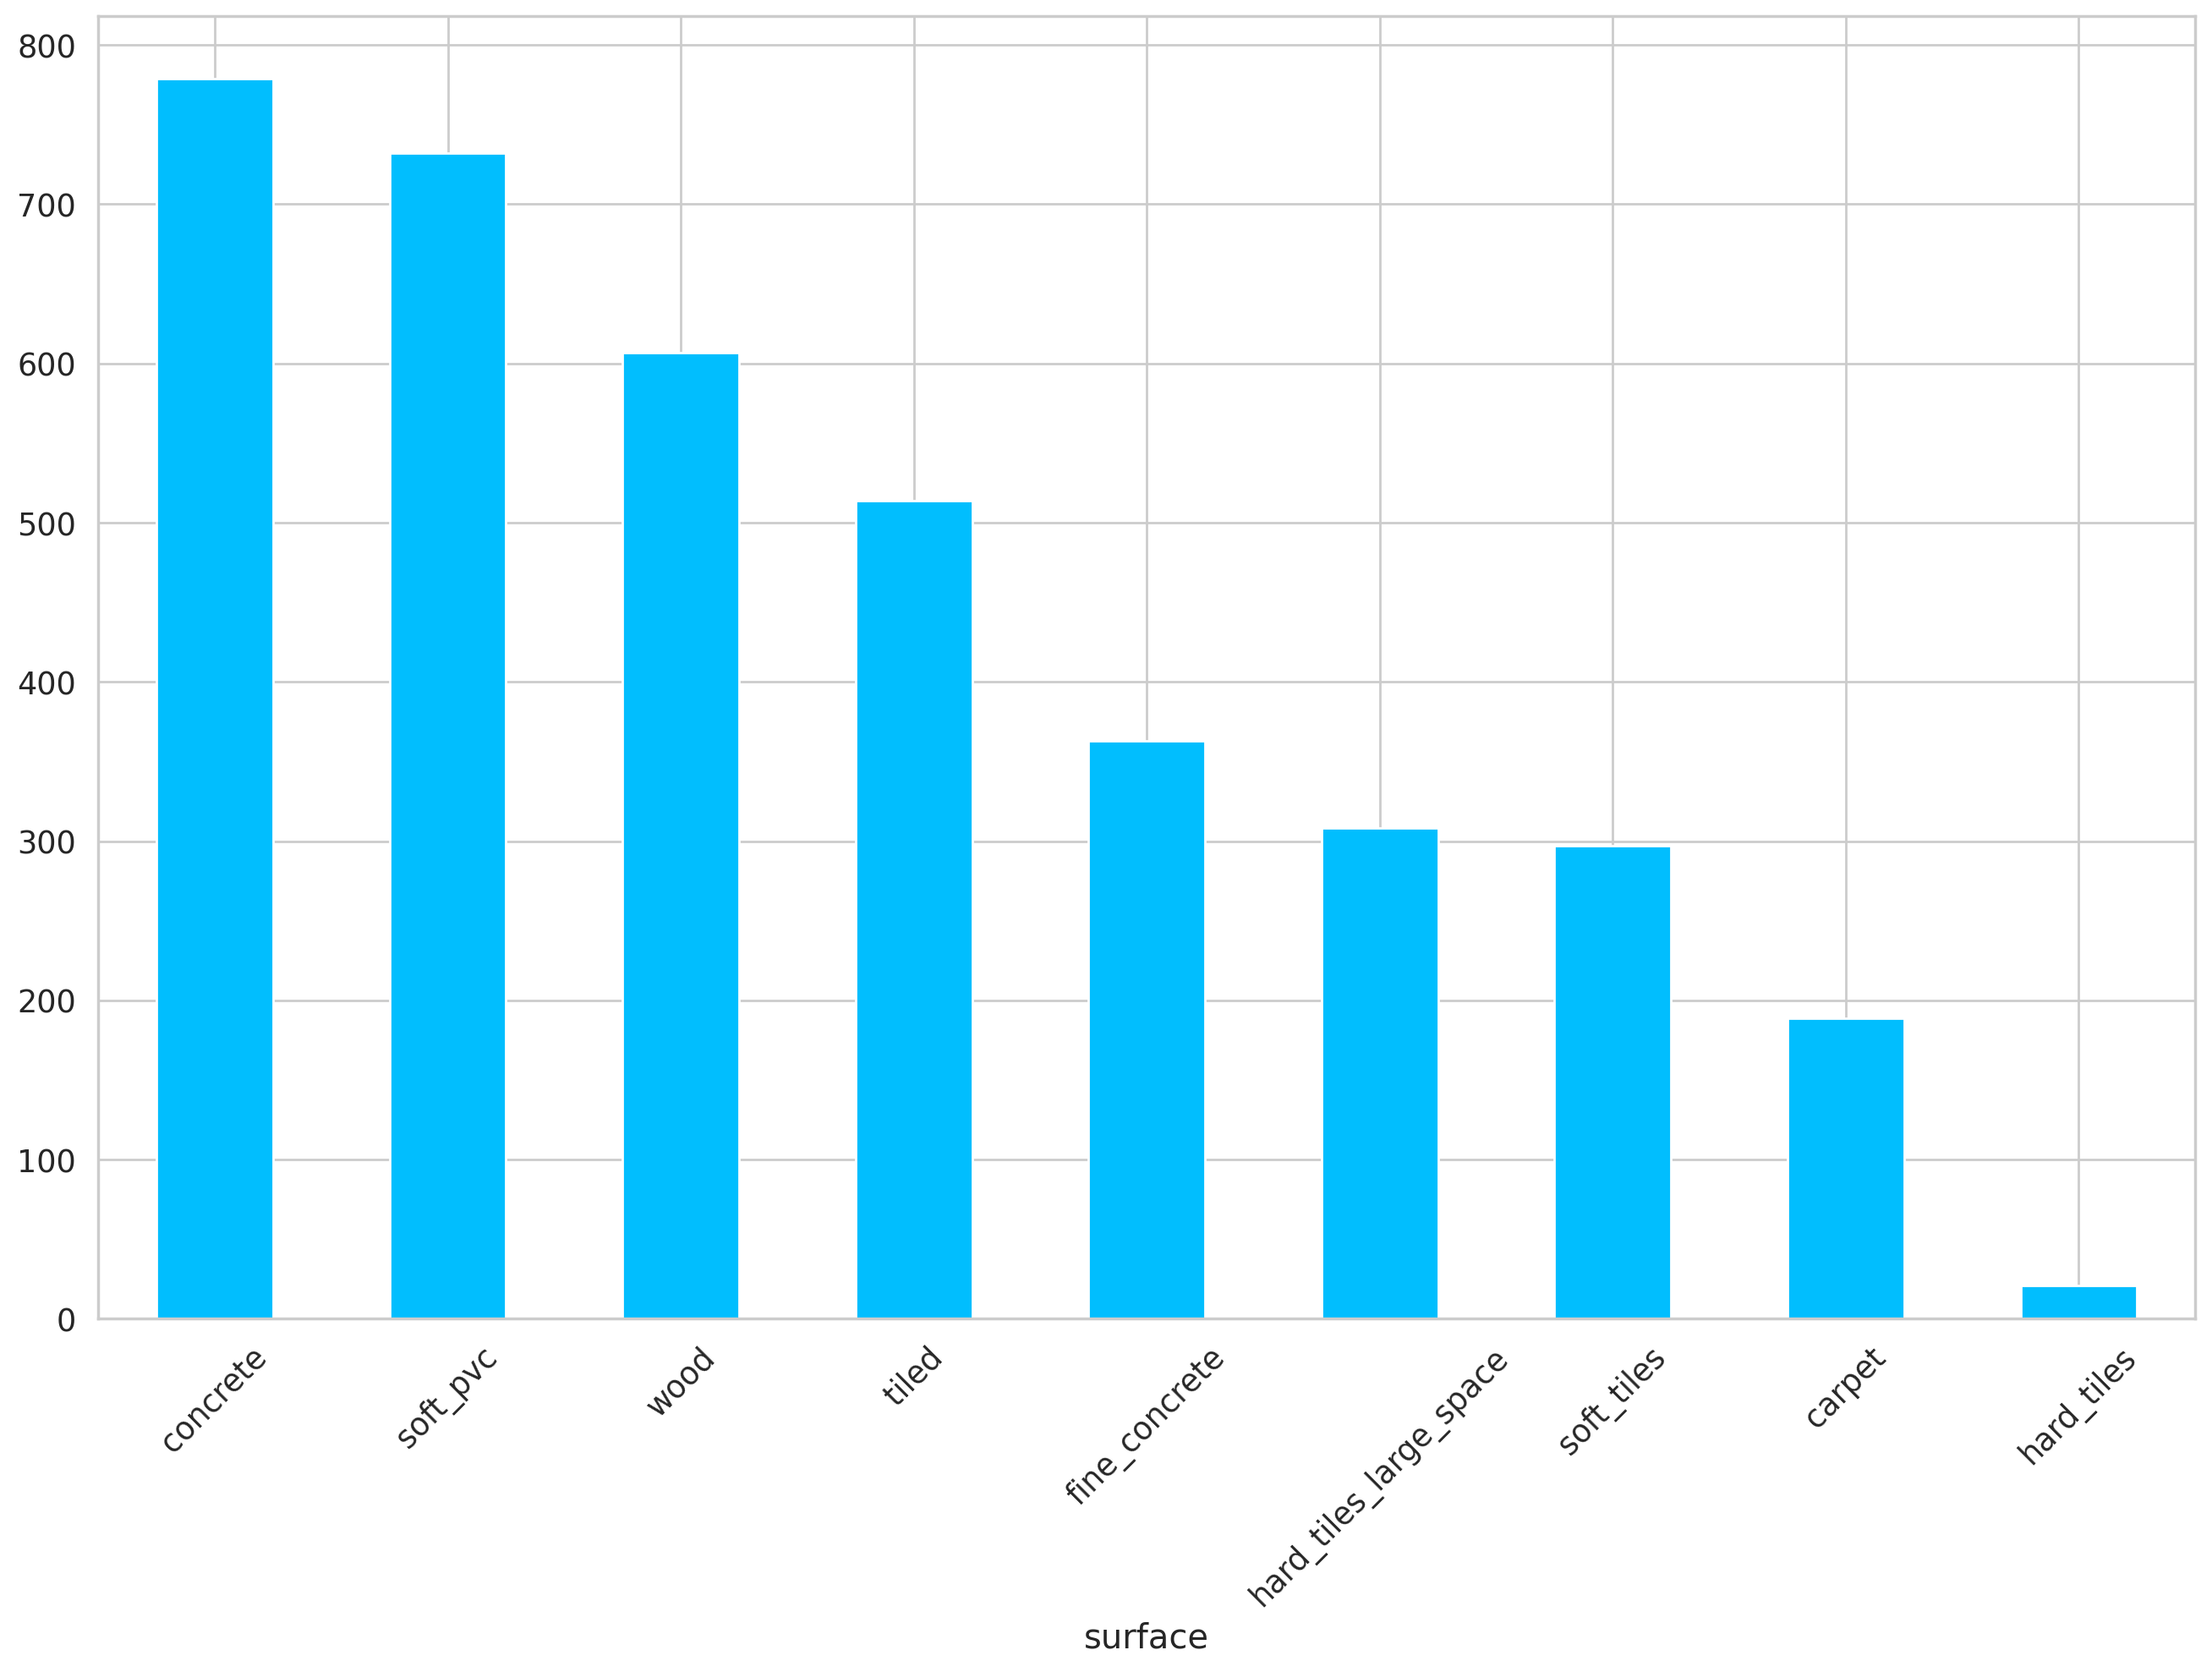

In [8]:
y_train.surface.value_counts().plot(kind="bar")
plt.xticks(rotation=45)
plt.show()

#### Encode surface labels

In [9]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(y_train.surface)
encoded_labels[:5]

array([2, 1, 1, 1, 6])

In [10]:
label_encoder.classes_

array(['carpet', 'concrete', 'fine_concrete', 'hard_tiles',
       'hard_tiles_large_space', 'soft_pvc', 'soft_tiles', 'tiled',
       'wood'], dtype=object)

In [11]:
y_train["labels"] = encoded_labels
y_train.head()

,series_id,group_id,surface,labels
0,0,13,fine_concrete,2
1,1,31,concrete,1
2,2,20,concrete,1
3,3,31,concrete,1
4,4,22,soft_tiles,6


#### Define feature columns

In [12]:
X_train.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003386,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410


In [13]:
FEATURE_COLUMNS = X_train.columns.to_list()[3:]
FEATURE_COLUMNS

['orientation_X',
 'orientation_Y',
 'orientation_Z',
 'orientation_W',
 'angular_velocity_X',
 'angular_velocity_Y',
 'angular_velocity_Z',
 'linear_acceleration_X',
 'linear_acceleration_Y',
 'linear_acceleration_Z']

In [14]:
X_train.series_id.value_counts()

series_id
0       128
2544    128
2532    128
2533    128
2534    128
       ... 
1274    128
1275    128
1276    128
1277    128
3809    128
Name: count, Length: 3810, dtype: int64

In [15]:
(X_train.series_id.value_counts() == 128).sum() == len(y_train)

True

#### Create sequences from the dataset

In [16]:
sequences = []
for series_id, group in X_train.groupby("series_id"):
    sequence_features = group[FEATURE_COLUMNS]
    label = y_train[y_train.series_id == series_id].iloc[0].labels
    sequences.append((sequence_features, label))

In [17]:
sequences[0]
# there are 3810 sequences of 128 observations each so each sequence corresponds to a y_train,
# while x_train consists of 3810 sequences * 128 observations each = 487680 observations

(     orientation_X  orientation_Y  orientation_Z  orientation_W  \
 0         -0.75853       -0.63435       -0.10488       -0.10597   
 1         -0.75853       -0.63434       -0.10490       -0.10600   
 2         -0.75853       -0.63435       -0.10492       -0.10597   
 3         -0.75852       -0.63436       -0.10495       -0.10597   
 4         -0.75852       -0.63435       -0.10495       -0.10596   
 ..             ...            ...            ...            ...   
 123       -0.75943       -0.63316       -0.10470       -0.10677   
 124       -0.75945       -0.63313       -0.10473       -0.10683   
 125       -0.75949       -0.63309       -0.10467       -0.10690   
 126       -0.75950       -0.63307       -0.10464       -0.10693   
 127       -0.75953       -0.63306       -0.10461       -0.10684   
 
      angular_velocity_X  angular_velocity_Y  angular_velocity_Z  \
 0              0.107650            0.017561            0.000767   
 1              0.067851            0.029939  

#### Split into training and testing sequences

In [18]:
train_sequences, test_sequences = train_test_split(sequences, test_size=0.2)
len(train_sequences), len(test_sequences)

(3048, 762)

## Dataset

In [19]:
class SurfaceDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences
    def __len__(self):
        return len(self.sequences)
    def __getitem__(self, index):
        sequence, label = self.sequences[index]
        return dict(
            sequence = torch.Tensor(sequence.to_numpy()),
            label = torch.tensor(label).long()
        )

In [20]:
class SurfaceDataModule(pl.LightningDataModule):
    def __init__(self, train_sequences, test_sequences, batch_size):
        super().__init__()
        self.train_sequences = train_sequences
        self.test_sequences = test_sequences
        self.batch_size = batch_size

    def setup(self, stage=None):
        self.train_dataset = SurfaceDataset(self.train_sequences)
        self.test_dataset = SurfaceDataset(self.test_sequences)

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=0) # cpu_count()

    def val_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=0) # cpu_count()

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=0) # cpu_count()

In [21]:
N_EPOCHS = 25#0
BATCH_SIZE = 64

data_module = SurfaceDataModule(train_sequences, test_sequences, BATCH_SIZE)

## Model

In [22]:
class SequenceModel(nn.Module):
    def __init__(self, n_features, n_classes, n_hidden=256, n_layers=3):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=n_hidden,
            num_layers=n_layers,
            batch_first=True,
            dropout=0.75 # trial and error
        )
        self.classifier = nn.Linear(n_hidden, n_classes)

    def forward(self, x):
        self.lstm.flatten_parameters()
        _, (hidden, _) = self.lstm(x)
        out = hidden[-1]
        return self.classifier(out)

In [23]:
class SurfacePredictor(pl.LightningModule):
    def __init__(self, n_features : int, n_classes : int):
        super().__init__()
        self.model = SequenceModel(n_features, n_classes)
        self.criterion = nn.CrossEntropyLoss()
        self.n_classes = n_classes

    def forward(self, x, labels=None):
        output = self.model(x)
        loss = 0
        if labels is not None:
            loss = self.criterion(output, labels)
        return loss, output

    def training_step(self, batch):
        sequence = batch["sequence"] # SurfaceDataset element
        label = batch["label"]
        loss, output = self(sequence, label) # forward method
        prediction = torch.argmax(output, dim=1)
        step_accuracy = accuracy(prediction, label, task="multiclass", num_classes=self.n_classes)

        self.log("train loss", loss, prog_bar=True, logger=True)
        self.log("train accuracy", step_accuracy, prog_bar=True, logger=True)
        return {"loss" : loss, "accuracy" : step_accuracy}

    def validation_step(self, batch):
        sequence = batch["sequence"] # SurfaceDataset element
        label = batch["label"]
        loss, output = self(sequence, label) # forward method
        prediction = torch.argmax(output, dim=1)
        step_accuracy = accuracy(prediction, label, task="multiclass", num_classes=self.n_classes)
        
        self.log("val loss", loss, prog_bar=True, logger=True)
        self.log("val accuracy", step_accuracy, prog_bar=True, logger=True)
        return {"loss" : loss, "accuracy" : step_accuracy}
    
    def test_step(self, batch):
        sequence = batch["sequence"] # SurfaceDataset element
        label = batch["label"]
        loss, output = self(sequence, label) # forward method
        prediction = torch.argmax(output, dim=1)
        step_accuracy = accuracy(prediction, label, task="multiclass", num_classes=self.n_classes)

        self.log("test loss", loss, prog_bar=True, logger=True)
        self.log("test accuracy", step_accuracy, prog_bar=True, logger=True)
        return {"loss" : loss, "accuracy" : step_accuracy}

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=0.0001)

In [24]:
model = SurfacePredictor(
    n_features=len(FEATURE_COLUMNS),
    n_classes=len(label_encoder.classes_)
)

In [25]:
checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints",
    filename="best-checkpoint",
    save_top_k=1,
    verbose=True,
    monitor="val loss",
    mode="min"
)
logger = TensorBoardLogger("lightning_logs", name="surface")
trainer = pl.Trainer(
    logger = logger,
    callbacks=[checkpoint_callback],
    max_epochs=N_EPOCHS,
    enable_progress_bar=True,
    #accelerator='gpu',
    accelerator='cpu',
    devices=1,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [26]:
trainer.fit(model, data_module)

Missing logger folder: lightning_logs/surface
/home/dema/anaconda3/envs/secml_venv/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/dema/Desktop/checkpoints exists and is not empty.

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | SequenceModel    | 1.3 M 
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.318     Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/home/dema/anaconda3/envs/secml_venv/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


/home/dema/anaconda3/envs/secml_venv/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/dema/anaconda3/envs/secml_venv/lib/python3.8/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (48) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0: 100%|██████████| 48/48 [00:14<00:00,  3.38it/s, v_num=0, train loss=1.900, train accuracy=0.225, val loss=2.040, val accuracy=0.226]

Epoch 0, global step 48: 'val loss' reached 2.04105 (best 2.04105), saving model to '/home/dema/Desktop/checkpoints/best-checkpoint-v1.ckpt' as top 1


Epoch 1: 100%|██████████| 48/48 [00:15<00:00,  3.18it/s, v_num=0, train loss=1.990, train accuracy=0.225, val loss=2.040, val accuracy=0.185] 

Epoch 1, global step 96: 'val loss' reached 2.03864 (best 2.03864), saving model to '/home/dema/Desktop/checkpoints/best-checkpoint-v1.ckpt' as top 1


Epoch 2: 100%|██████████| 48/48 [00:15<00:00,  3.15it/s, v_num=0, train loss=1.950, train accuracy=0.175, val loss=2.030, val accuracy=0.193] 

Epoch 2, global step 144: 'val loss' reached 2.02544 (best 2.02544), saving model to '/home/dema/Desktop/checkpoints/best-checkpoint-v1.ckpt' as top 1


Epoch 3: 100%|██████████| 48/48 [00:15<00:00,  3.13it/s, v_num=0, train loss=1.960, train accuracy=0.150, val loss=1.990, val accuracy=0.260]

Epoch 3, global step 192: 'val loss' reached 1.98785 (best 1.98785), saving model to '/home/dema/Desktop/checkpoints/best-checkpoint-v1.ckpt' as top 1


Epoch 4: 100%|██████████| 48/48 [00:15<00:00,  3.07it/s, v_num=0, train loss=1.830, train accuracy=0.375, val loss=1.980, val accuracy=0.253]

Epoch 4, global step 240: 'val loss' reached 1.97776 (best 1.97776), saving model to '/home/dema/Desktop/checkpoints/best-checkpoint-v1.ckpt' as top 1


Epoch 5: 100%|██████████| 48/48 [00:15<00:00,  3.03it/s, v_num=0, train loss=1.840, train accuracy=0.300, val loss=1.940, val accuracy=0.264]

Epoch 5, global step 288: 'val loss' reached 1.93891 (best 1.93891), saving model to '/home/dema/Desktop/checkpoints/best-checkpoint-v1.ckpt' as top 1


Epoch 6: 100%|██████████| 48/48 [00:15<00:00,  3.00it/s, v_num=0, train loss=1.970, train accuracy=0.175, val loss=1.940, val accuracy=0.299]

Epoch 6, global step 336: 'val loss' reached 1.93645 (best 1.93645), saving model to '/home/dema/Desktop/checkpoints/best-checkpoint-v1.ckpt' as top 1


Epoch 7: 100%|██████████| 48/48 [00:22<00:00,  2.16it/s, v_num=0, train loss=1.830, train accuracy=0.300, val loss=1.700, val accuracy=0.374]

Epoch 7, global step 384: 'val loss' reached 1.70336 (best 1.70336), saving model to '/home/dema/Desktop/checkpoints/best-checkpoint-v1.ckpt' as top 1


Epoch 8: 100%|██████████| 48/48 [00:27<00:00,  1.75it/s, v_num=0, train loss=1.700, train accuracy=0.400, val loss=1.690, val accuracy=0.340]

Epoch 8, global step 432: 'val loss' reached 1.68616 (best 1.68616), saving model to '/home/dema/Desktop/checkpoints/best-checkpoint-v1.ckpt' as top 1


Epoch 9: 100%|██████████| 48/48 [00:15<00:00,  3.04it/s, v_num=0, train loss=1.710, train accuracy=0.250, val loss=1.750, val accuracy=0.307]

Epoch 9, global step 480: 'val loss' was not in top 1


Epoch 10: 100%|██████████| 48/48 [00:15<00:00,  3.11it/s, v_num=0, train loss=1.430, train accuracy=0.400, val loss=1.530, val accuracy=0.399]

Epoch 10, global step 528: 'val loss' reached 1.53294 (best 1.53294), saving model to '/home/dema/Desktop/checkpoints/best-checkpoint-v1.ckpt' as top 1


Epoch 11: 100%|██████████| 48/48 [00:22<00:00,  2.16it/s, v_num=0, train loss=1.830, train accuracy=0.275, val loss=1.560, val accuracy=0.383]

Epoch 11, global step 576: 'val loss' was not in top 1


Epoch 12: 100%|██████████| 48/48 [00:26<00:00,  1.80it/s, v_num=0, train loss=1.270, train accuracy=0.575, val loss=1.530, val accuracy=0.425]

Epoch 12, global step 624: 'val loss' reached 1.52762 (best 1.52762), saving model to '/home/dema/Desktop/checkpoints/best-checkpoint-v1.ckpt' as top 1


Epoch 13: 100%|██████████| 48/48 [00:14<00:00,  3.21it/s, v_num=0, train loss=1.720, train accuracy=0.225, val loss=1.560, val accuracy=0.396]

Epoch 13, global step 672: 'val loss' was not in top 1


Epoch 14: 100%|██████████| 48/48 [00:15<00:00,  3.10it/s, v_num=0, train loss=1.600, train accuracy=0.425, val loss=1.480, val accuracy=0.425]

Epoch 14, global step 720: 'val loss' reached 1.48003 (best 1.48003), saving model to '/home/dema/Desktop/checkpoints/best-checkpoint-v1.ckpt' as top 1


Epoch 15: 100%|██████████| 48/48 [00:15<00:00,  3.08it/s, v_num=0, train loss=1.550, train accuracy=0.350, val loss=1.500, val accuracy=0.415]

Epoch 15, global step 768: 'val loss' was not in top 1


Epoch 16: 100%|██████████| 48/48 [00:15<00:00,  3.06it/s, v_num=0, train loss=1.370, train accuracy=0.425, val loss=1.480, val accuracy=0.412]

Epoch 16, global step 816: 'val loss' was not in top 1


Epoch 17: 100%|██████████| 48/48 [00:15<00:00,  3.02it/s, v_num=0, train loss=1.480, train accuracy=0.425, val loss=1.500, val accuracy=0.411]

Epoch 17, global step 864: 'val loss' was not in top 1


Epoch 18: 100%|██████████| 48/48 [00:15<00:00,  3.04it/s, v_num=0, train loss=1.500, train accuracy=0.450, val loss=1.550, val accuracy=0.361]

Epoch 18, global step 912: 'val loss' was not in top 1


Epoch 19: 100%|██████████| 48/48 [00:15<00:00,  3.05it/s, v_num=0, train loss=1.660, train accuracy=0.400, val loss=1.460, val accuracy=0.450]

Epoch 19, global step 960: 'val loss' reached 1.45693 (best 1.45693), saving model to '/home/dema/Desktop/checkpoints/best-checkpoint-v1.ckpt' as top 1


Epoch 20: 100%|██████████| 48/48 [00:15<00:00,  3.04it/s, v_num=0, train loss=1.470, train accuracy=0.525, val loss=1.390, val accuracy=0.497]

Epoch 20, global step 1008: 'val loss' reached 1.38525 (best 1.38525), saving model to '/home/dema/Desktop/checkpoints/best-checkpoint-v1.ckpt' as top 1


Epoch 21: 100%|██████████| 48/48 [00:23<00:00,  2.03it/s, v_num=0, train loss=1.300, train accuracy=0.450, val loss=1.440, val accuracy=0.441]

Epoch 21, global step 1056: 'val loss' was not in top 1


Epoch 22: 100%|██████████| 48/48 [00:27<00:00,  1.76it/s, v_num=0, train loss=1.070, train accuracy=0.650, val loss=1.420, val accuracy=0.432]

Epoch 22, global step 1104: 'val loss' was not in top 1


Epoch 23: 100%|██████████| 48/48 [00:14<00:00,  3.25it/s, v_num=0, train loss=1.350, train accuracy=0.500, val loss=1.520, val accuracy=0.453]

Epoch 23, global step 1152: 'val loss' was not in top 1


Epoch 24: 100%|██████████| 48/48 [00:15<00:00,  3.08it/s, v_num=0, train loss=1.280, train accuracy=0.550, val loss=1.330, val accuracy=0.497]

Epoch 24, global step 1200: 'val loss' reached 1.32911 (best 1.32911), saving model to '/home/dema/Desktop/checkpoints/best-checkpoint-v1.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 48/48 [00:15<00:00,  3.07it/s, v_num=0, train loss=1.280, train accuracy=0.550, val loss=1.330, val accuracy=0.497]


In [33]:
trained_model = SurfacePredictor.load_from_checkpoint(
    trainer.checkpoint_callback.best_model_path,
    n_features=len(FEATURE_COLUMNS),
    n_classes=len(label_encoder.classes_)
)
trained_model.freeze()
test_dataset = SurfaceDataset(test_sequences)

predictions = []
labels = []
for item in tqdm(test_dataset):
    sequence = item["sequence"]
    label = item["label"]

    _, output = trained_model(sequence.unsqueeze(dim=0))
    prediction = torch.argmax(output, dim=1)
    predictions.append(prediction.item())
    labels.append(label.item())

  0%|          | 0/762 [00:00<?, ?it/s]

100%|██████████| 762/762 [00:03<00:00, 202.45it/s]


In [34]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel("True surface")
    plt.xlabel("Predicted surface")

In [35]:
cm = confusion_matrix(labels, predictions)
df_cm = pd.DataFrame(
    cm,
    index=label_encoder.classes_,
    columns=label_encoder.classes_
)
df_cm

,carpet,concrete,fine_concrete,hard_tiles,hard_tiles_large_space,soft_pvc,soft_tiles,tiled,wood
carpet,0,13,14,0,8,0,0,0,12
concrete,0,132,5,0,14,17,0,2,2
fine_concrete,0,15,17,0,0,14,0,9,10
hard_tiles,0,0,0,0,0,2,3,0,0
hard_tiles_large_space,3,2,8,0,43,0,0,2,5
soft_pvc,0,4,7,0,1,92,9,1,27
soft_tiles,1,0,2,0,2,12,30,0,16
tiled,0,49,1,0,2,12,0,25,0
wood,0,20,4,0,10,24,11,8,40


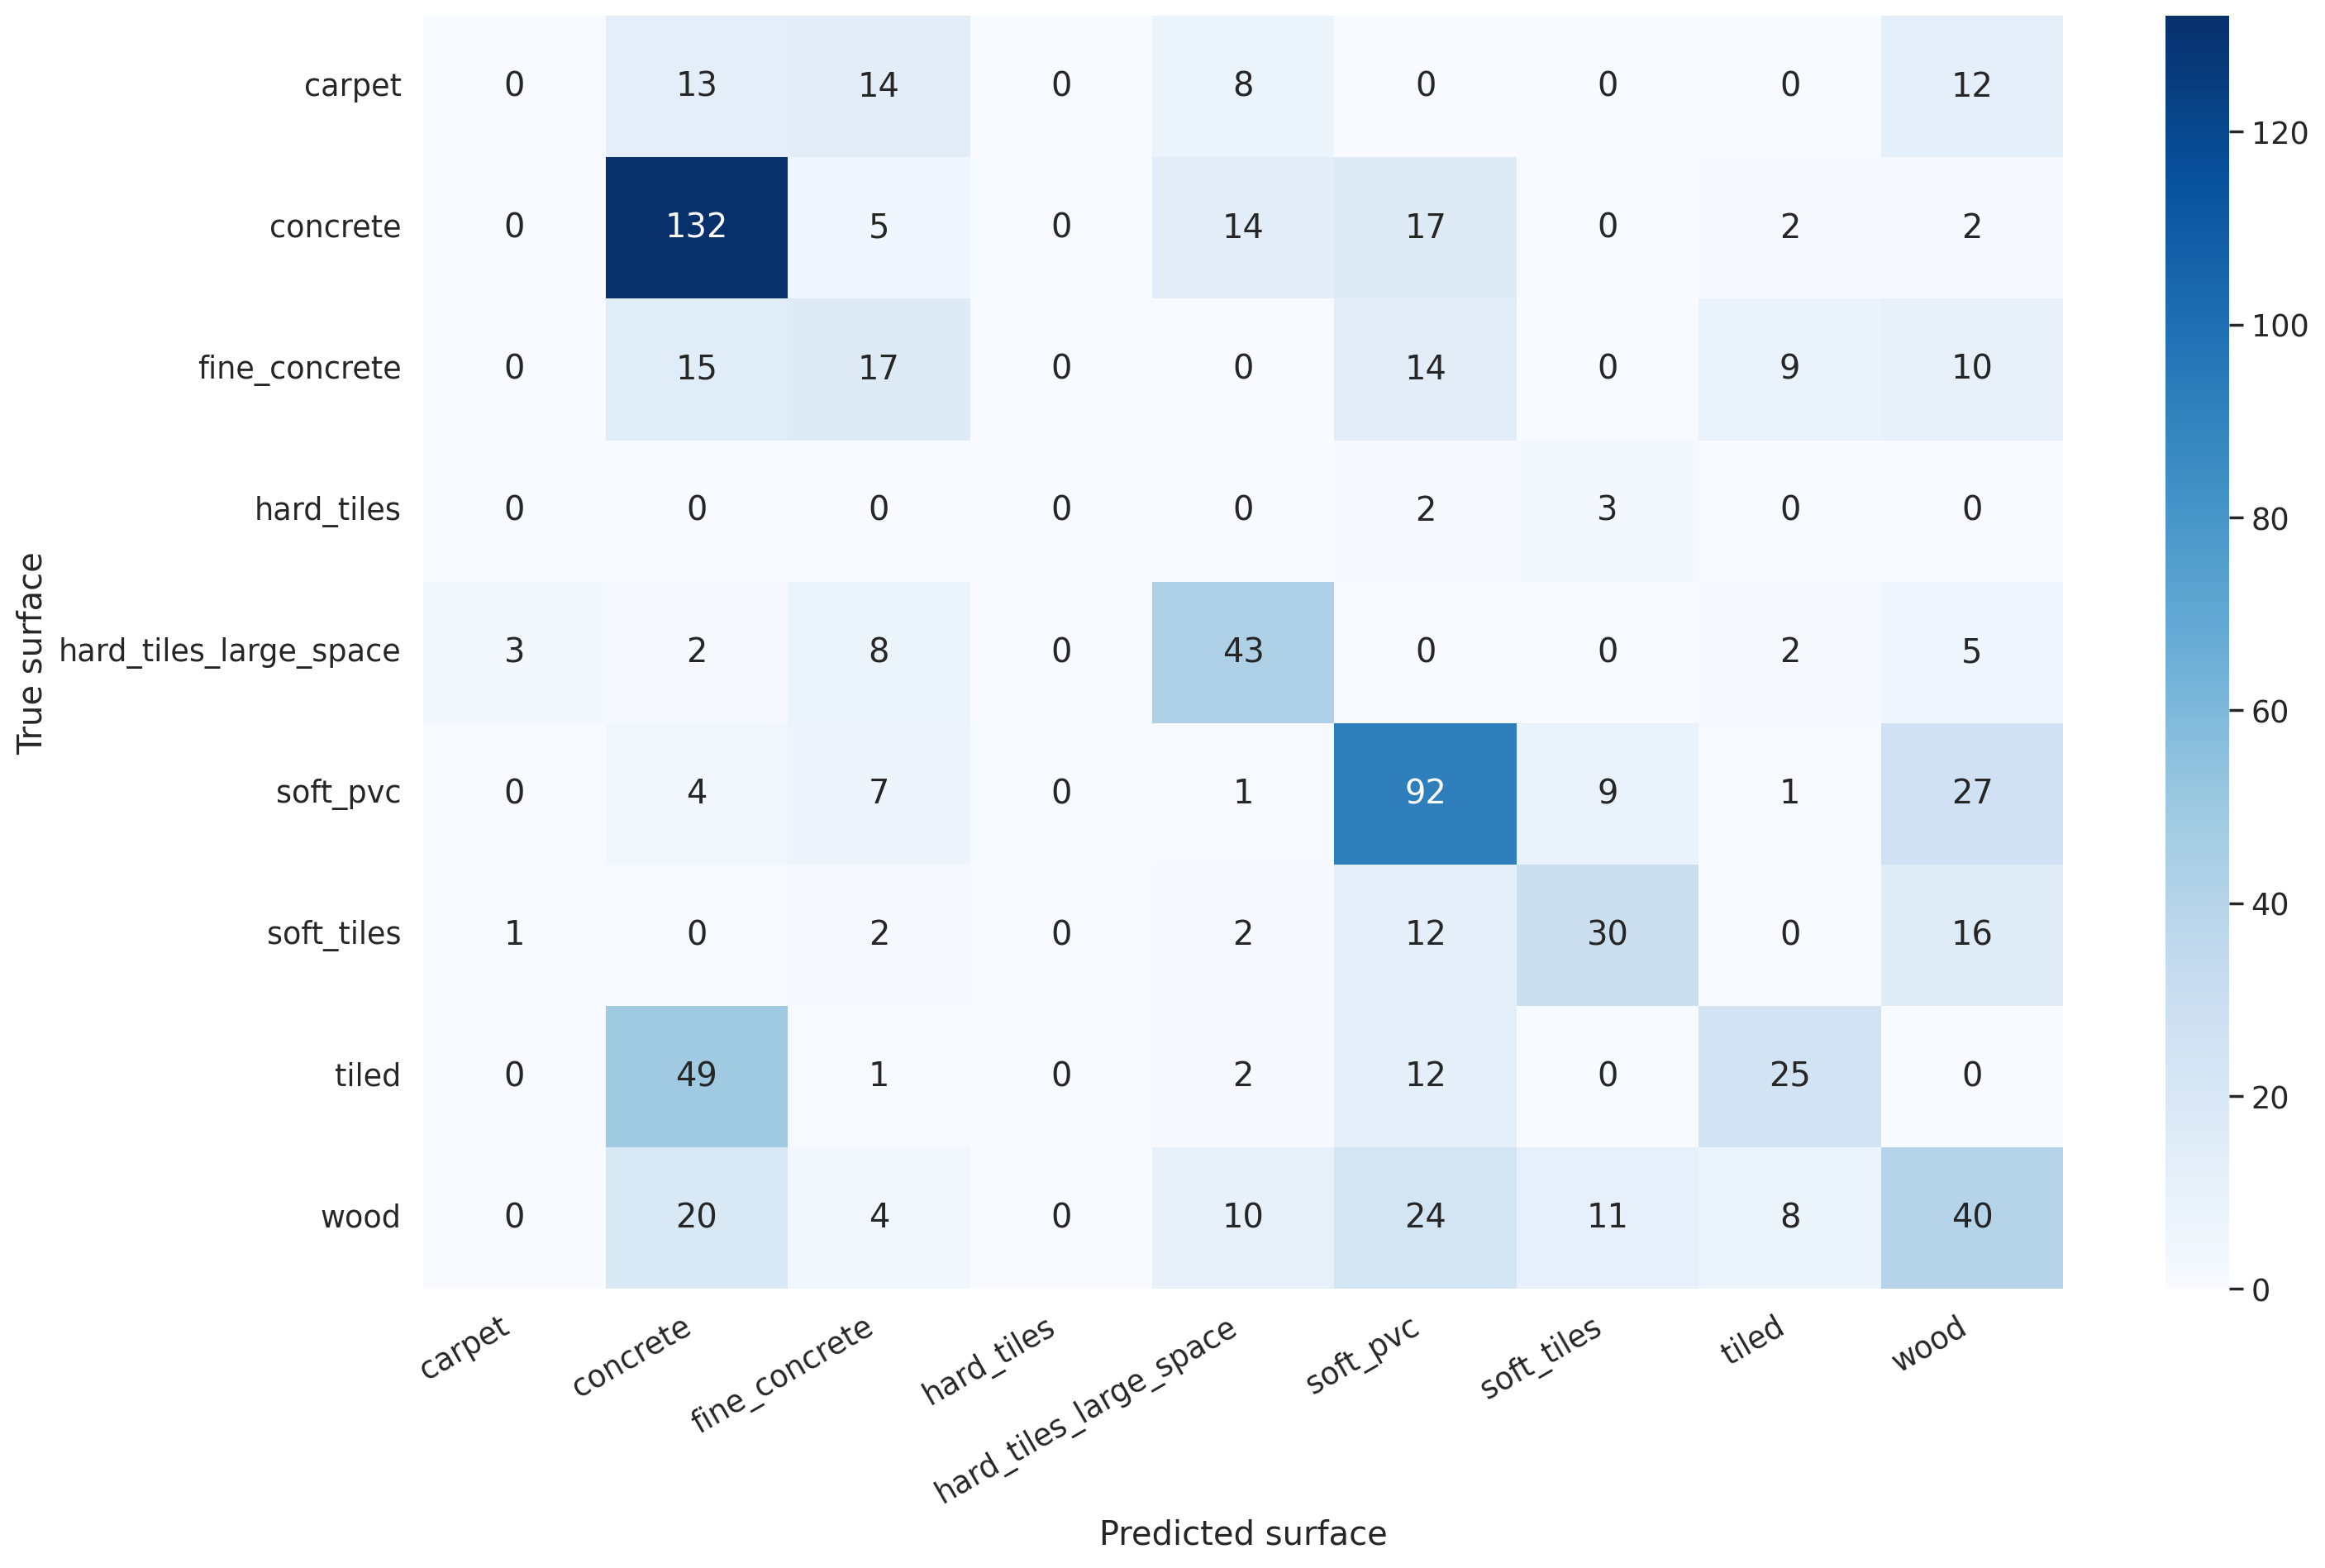

In [36]:
show_confusion_matrix(df_cm)